In [82]:
"""Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis
"""

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_wide_receiver_quarterback_headers
from get_df import get_wide_receiver_df, all_individual_stats, fantasy_points

import matplotlib.pyplot as plt
%matplotlib inline

import patsy
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [29]:
# df_all_wide_receivers_2019 = all_position_stats('2019','receiving',40)
# df_all_wide_receivers_2019.columns = all_wide_receiver_quarterback_headers('2019','receiving')
# df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']] = df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']].apply(pd.to_numeric)
# df_all_wide_receivers_2019 = df_all_wide_receivers_2019[(df_all_wide_receivers_2019.Pos != 'RB') & (df_all_wide_receivers_2019.Pos != 'rb')] 
# df_all_wide_receivers_2019 = df_all_wide_receivers_2019[df_all_wide_receivers_2019['Yds'] > 700]
# df_all_wide_receivers_2019 = df_all_wide_receivers_2019.sort_values('Yds',ascending=False)

# Pickling
# df_all_wide_receivers_2019.to_pickle("./pickled/df_all_wide_receivers_2019.pkl")
df_all_wide_receivers_2019 = pd.read_pickle("./pickled/df_all_wide_receivers_2019.pkl")
df_all_wide_receivers_2019

,Link,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb
Michael Thomas,/players/T/ThomMi05.htm,Michael Thomas*+,NOR,26,WR,16,15,185,149,80.5%,1725,11.6,9,91,49,9.3,9.3,107.8,1
Julio Jones,/players/J/JoneJu02.htm,Julio Jones *,ATL,30,WR,15,15,157,99,63.1%,1394,14.1,6,77,54,8.9,6.6,92.9,1
Chris Godwin,/players/G/GodwCh00.htm,Chris Godwin*,TAM,23,WR,14,14,121,86,71.1%,1333,15.5,9,63,71,11.0,6.1,95.2,0
Travis Kelce,/players/K/KelcTr00.htm,Travis Kelce*,KAN,30,TE,16,16,136,97,71.3%,1229,12.7,5,65,47,9.0,6.1,76.8,1
DeVante Parker,/players/P/ParkDe01.htm,DeVante Parker,MIA,26,WR,16,14,128,72,56.3%,1202,16.7,9,58,51,9.4,4.5,75.1,0
Keenan Allen,/players/A/AlleKe00.htm,Keenan Allen*,LAC,27,WR,16,16,149,104,69.8%,1199,11.5,6,63,45,8.0,6.5,74.9,0
Amari Cooper,/players/C/CoopAm00.htm,Amari Cooper*,DAL,25,WR,16,16,119,79,66.4%,1189,15.1,8,54,53,10.0,4.9,74.3,0
D.J. Moore,/players/M/MoorD.00.htm,D.J. Moore,CAR,22,WR,15,15,135,87,64.4%,1175,13.5,4,63,52,8.7,5.8,78.3,2
Jarvis Landry,/players/L/LandJa00.htm,Jarvis Landry *,CLE,27,WR,16,16,138,83,60.1%,1174,14.1,6,55,65,8.5,5.2,73.4,0
DeAndre Hopkins,/players/H/HopkDe00.htm,DeAndre Hopkins*+,HOU,27,WR,15,15,150,104,69.3%,1165,11.2,7,68,43,7.8,6.9,77.7,0


In [30]:
# all_wide_receivers_2019 = all_individual_stats(get_wide_receiver_df, df_all_wide_receivers_2019, '2019')
# all_wide_receivers_2019.to_pickle("./pickled/all_wide_receivers_2019.pkl")

all_wide_receivers_2019 = pd.read_pickle("./pickled/all_wide_receivers_2019.pkl")
all_wide_receivers_2019

,index,Name,Date,Game,Week,Team,Opp,Result,Targets,Receptions,Total_Yards,Yards_per_Reception,Touchdowns,Catch%
0,0,Michael Thomas,2019-09-09,1,1,NOR,HOU,W 30-28,13,10.0,123.0,12.30,0.0,76.9%
1,1,Michael Thomas,2019-09-15,2,2,NOR,LAR,L 9-27,13,10.0,89.0,8.90,0.0,76.9%
2,2,Michael Thomas,2019-09-22,3,3,NOR,SEA,W 33-27,7,5.0,54.0,10.80,1.0,71.4%
3,3,Michael Thomas,2019-09-29,4,4,NOR,DAL,W 12-10,9,9.0,95.0,10.56,0.0,100.0%
4,4,Michael Thomas,2019-10-06,5,5,NOR,TAM,W 31-24,13,11.0,182.0,16.55,2.0,84.6%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,7,Christian Kirk,2019-11-17,11,11,ARI,SFO,L 26-36,9,6.0,41.0,6.83,0.0,66.7%
464,8,Christian Kirk,2019-12-01,12,13,ARI,LAR,L 7-34,7,3.0,23.0,7.67,0.0,42.9%
465,9,Christian Kirk,2019-12-08,13,14,ARI,PIT,L 17-23,9,8.0,85.0,10.63,0.0,88.9%
466,10,Christian Kirk,2019-12-15,14,15,ARI,CLE,W 38-24,5,4.0,33.0,8.25,0.0,80.0%


In [47]:
# all_wide_receivers_fantasy_2019 = all_individual_stats(fantasy_points, df_all_wide_receivers_2019, '2019')
# all_wide_receivers_fantasy_2019.to_pickle("./pickled/all_wide_receivers_fantasy_2019.pkl")

all_wide_receivers_fantasy_2019 = pd.read_pickle("./pickled/all_wide_receivers_fantasy_2019.pkl")
all_wide_receivers_fantasy_2019[:16]

,index,Name,Fantasy_Points
0,1,Michael Thomas,8.9
1,2,Michael Thomas,11.4
2,3,Michael Thomas,9.5
3,4,Michael Thomas,30.2
4,5,Michael Thomas,8.9
5,6,Michael Thomas,13.1
6,7,Michael Thomas,16.3
7,8,Michael Thomas,15.2
8,9,Michael Thomas,17.4
9,10,Michael Thomas,16.1


In [57]:
all_wide_receivers_fantasy_2019.rolling(4).mean()
all_wide_receivers_fantasy_2019.expanding().mean()[:15]

,index,Fantasy_Points
0,1.0,8.900000
1,1.5,10.150000
2,2.0,9.933333
3,2.5,15.000000
4,3.0,13.780000
5,3.5,13.666667
6,4.0,14.042857
7,4.5,14.187500
8,5.0,14.544444
9,5.5,14.700000


In [86]:
# df_receiving_fantasy_2019 = all_wide_receivers_2019.iloc[:,1:2]

# df_receiving_fantasy_2019['Fantasy_Points'] = all_wide_receivers_fantasy_2019.iloc[:,-1:]

# receptions_points = all_wide_receivers_2019.iloc[:,9:10]
# df_receiving_fantasy_2019['Total_Reception'] = receptions_points['Receptions']

# receiving_yard_points = all_wide_receivers_2019.iloc[:,10:11]
# df_receiving_fantasy_2019['Total_Yards'] = receiving_yard_points['Total_Yards']

# receiving_td_points = all_wide_receivers_2019.iloc[:,12:13]
# df_receiving_fantasy_2019['Total_TDs'] = receiving_td_points['Touchdowns']

# df_receiving_fantasy_2019 = df_receiving_fantasy_2019.dropna()

# df_receiving_fantasy_points = df_receiving_fantasy_2019[['Fantasy_Points']]

# df_receiving_fantasy_2019 = df_receiving_fantasy_2019.groupby('Name').expanding().mean().reset_index()

# df_receiving_fantasy_2019 = df_receiving_fantasy_2019.sort_values('level_1').reset_index()

# df_receiving_fantasy_2019['Fantasy_Points'] = df_receiving_fantasy_points.iloc[:,:1]

# df_receiving_fantasy_2019 = df_receiving_fantasy_2019.drop(['index','level_1'],axis=1)

# df_receiving_fantasy_2019 = df_receiving_fantasy_2019.dropna()

# df_receiving_fantasy_2019.to_pickle("./pickled/df_receiving_fantasy_2019.pkl")

df_receiving_fantasy_2019 = pd.read_pickle("./pickled/df_receiving_fantasy_2019.pkl")
df_receiving_fantasy_2019

,Name,Fantasy_Points,Total_Reception,Total_Yards,Total_TDs
0,Michael Thomas,8.9,10.000000,123.000000,0.000000
1,Michael Thomas,11.4,10.000000,106.000000,0.000000
2,Michael Thomas,9.5,8.333333,88.666667,0.333333
3,Michael Thomas,30.2,8.500000,90.250000,0.250000
4,Michael Thomas,8.9,9.000000,108.600000,0.600000
...,...,...,...,...,...
455,Christian Kirk,14.4,5.750000,63.500000,0.375000
456,Christian Kirk,11.4,5.444444,59.000000,0.333333
457,Christian Kirk,5.9,5.700000,61.600000,0.300000
458,Christian Kirk,4.3,5.545455,59.000000,0.272727


In [87]:
df_receiving_fantasy_2019.corr()

,Fantasy_Points,Total_Reception,Total_Yards,Total_TDs
Fantasy_Points,1.000000,0.099098,0.160581,0.203848
Total_Reception,0.099098,1.000000,0.645087,0.078657
Total_Yards,0.160581,0.645087,1.000000,0.355584
Total_TDs,0.203848,0.078657,0.355584,1.000000


<AxesSubplot:>

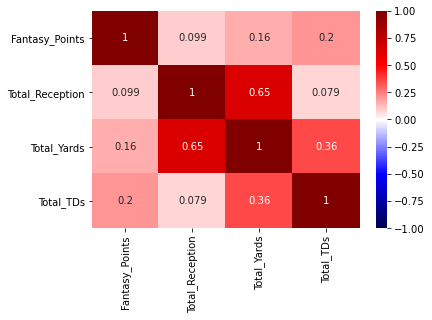

In [88]:
sns.heatmap(df_receiving_fantasy_2019.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)

<Figure size 2160x1440 with 0 Axes>

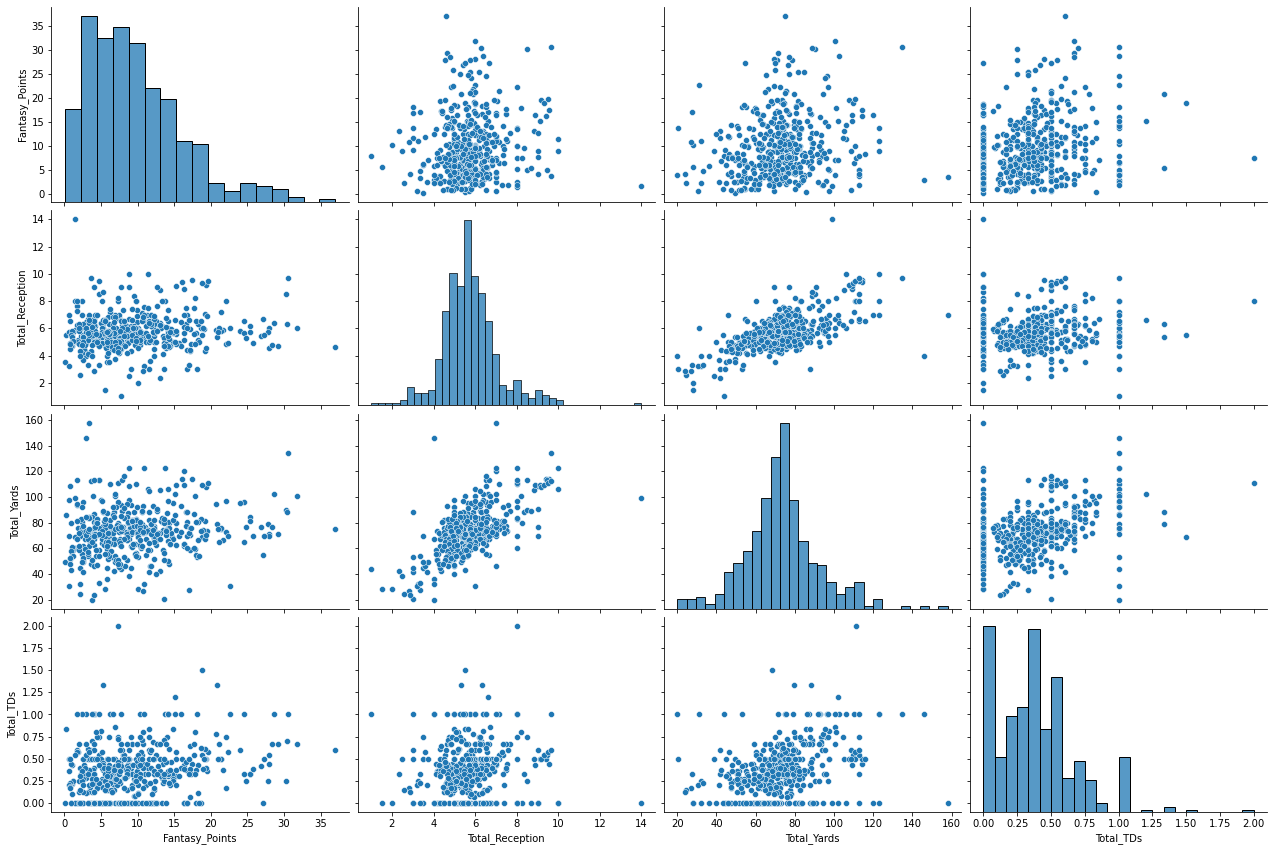

In [89]:
plt.figure(figsize = [30,20])

sns.pairplot(df_receiving_fantasy_2019, height=3, aspect=1.5)

In [90]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Total_Reception + Total_Yards + Total_TDs', data=df_receiving_fantasy_2019, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     8.061
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           3.06e-05
Time:                        01:30:10   Log-Likelihood:                -1476.7
No. Observations:                 452   AIC:                             2961.
Df Residuals:                     448   BIC:                             2978.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3779      1.387      3.877      0.000       2.652       8.104
Total_Reception     0.1789      0.295      0.606      0.545      -0.401       0.759
Total_Yards         0.0259      0.023      1.133      0.258      -0.019       0.071
Total_TDs           3.9323      1.136      3.463      0.001       1.701       6.164
==============================================================================
Omnibus:                       64.030   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.908
Skew:                           0.965   Prob(JB):                     1.82e-20
Kurtosis:                       4.050   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
# Define the model
lm1 = smf.ols('Fantasy_Points ~ Total_Yards + Total_TDs', data=df_receiving_fantasy_2019)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     11.92
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           8.99e-06
Time:                        01:30:10   Log-Likelihood:                -1476.8
No. Observations:                 452   AIC:                             2960.
Df Residuals:                     449   BIC:                             2972.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.7892      1.209      4.788      0.000       3.413       8.165
Total_Yards     0.0351      0.017      2.050      0.041       0.001       0.069
Total_TDs       3.7871      1.109      3.414      0.001       1.607       5.967
==============================================================================
Omnibus:                       63.554   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.748
Skew:                           0.963   Prob(JB):                     3.25e-20
Kurtosis:                       4.027   Cond. No.                         305.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

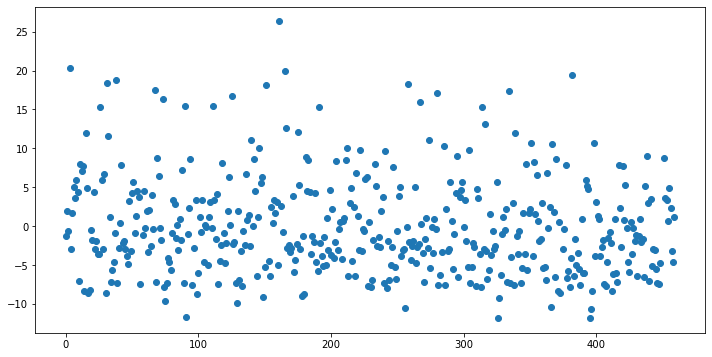

In [92]:
#Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random. I'm not sure if the below looks too random. It seems to be between 0, so what does that mean? May be missing actual functional dependency underlying the data. This data may not be linear but let's keep going. 
fit1.resid.plot(style='o',figsize=(12,6))

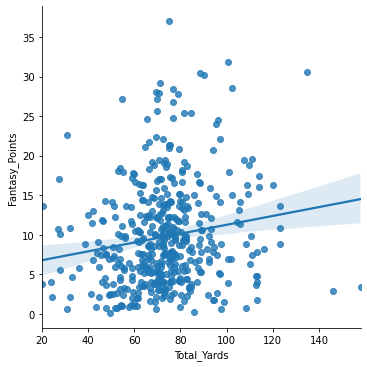

In [93]:
g = sns.lmplot(x='Total_Yards',y='Fantasy_Points',data=df_receiving_fantasy_2019)

## Linear Regression

In [95]:
# Create an empty model
lr = LinearRegression()

# Model is analogous to 'Fantasy_Points ~ Total_Yards_Points + Total_TD_Points' model
# Predictor variables. All but the first one 
X = df_receiving_fantasy_2019.iloc[:, 2:]

# Response variables
y = df_receiving_fantasy_2019.iloc[:, 1]

# # Model fit to full dataset
lr.fit(X,y)

# # Prints R^2 for the model against the full dataset 
lr.score(X,y)

0.05121590450375357

In [96]:
X_train, X_test, y_train, y_test = train_test_split(df_receiving_fantasy_2019[['Total_Reception', 'Total_Yards', 'Total_TDs']], df_receiving_fantasy_2019['Fantasy_Points'], test_size=0.33, random_state=100)

lr = LinearRegression()
lr.fit(X_train,y_train)
print("Training Score: ", lr.score(X_train,y_train), "Test Score: ", lr.score(X_test,y_test))

Training Score:  0.06019855024632892 Test Score:  0.027059919496029372


In [97]:
p = PolynomialFeatures(degree=2)

# X_train_array = np.array(X_train.tolist()).reshape(-1,1)
# X_test_array = np.array(X_test.tolist()).reshape(-1,1)

x_train_poly = p.fit_transform(X_train)
lr.fit(x_train_poly, y_train)
print("Training Score: ", lr.score(x_train_poly, y_train), "Test Score: " , lr.score(p.transform(X_test), y_test))

Training Score:  0.06883827922202823 Test Score:  0.022381521700572393


In [98]:
L = LassoCV()
s = StandardScaler(with_mean=False)
x_train_poly_scaled = s.fit_transform(x_train_poly)
L.fit(x_train_poly_scaled, y_train)

print("Training Score: ", L.score(x_train_poly_scaled, y_train), "Test Score: " , L.score(s.transform(p.transform(X_test)),y_test))

Training Score:  0.0549366930083347 Test Score:  0.016791517385404853


In [99]:
R = RidgeCV()
R.fit(x_train_poly_scaled, y_train)

print("Training Score: ", R.score(x_train_poly_scaled, y_train), "Test Score: " , R.score(s.transform(p.transform(X_test)),y_test))

Training Score:  0.06347334872696442 Test Score:  0.01519034184551371
